# Feature Engineering

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Feature engineering libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.decomposition import PCA
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Load cleaned datasets
processed_dir = Path('../data/processed')
market_df = pd.read_csv(processed_dir / 'ai_market_clean.csv')
popularity_df = pd.read_csv(processed_dir / 'ai_popularity_clean.csv')

## Growth Rate Features

In [2]:
# Create growth rate features
def create_growth_features(df, target_cols):
    """
    Create various growth rate indicators
    """
    df_features = df.copy()
    
    for col in target_cols:
        if col in df.columns:
            # Year-over-year growth rate
            df_features[f'{col}_yoy_growth'] = df[col].pct_change() * 100
            
            # Cumulative growth from base year
            base_value = df[col].iloc[0]
            df_features[f'{col}_cumulative_growth'] = ((df[col] / base_value) - 1) * 100
            
            # Rolling growth rate (2-year)
            df_features[f'{col}_rolling_2y_growth'] = df[col].rolling(window=2).apply(
                lambda x: ((x.iloc[-1] / x.iloc[0]) - 1) * 100 if len(x) == 2 and x.iloc[0] != 0 else np.nan
            )
            
            # Growth acceleration (second derivative)
            growth_rate = df[col].pct_change()
            df_features[f'{col}_growth_acceleration'] = growth_rate.diff()
    
    return df_features

# Define key columns for growth analysis
growth_columns = [
    'ai_software_revenue_in_billions',
    'global_ai_market_value_in_billions',
    'ai_adoption',
    'organizations_using_ai',
    'estimated_revenue_increase_from_ai_trillions_usd'
]

# Create growth features
market_with_growth = create_growth_features(market_df, growth_columns)

new_growth_cols = [col for col in market_with_growth.columns if 'growth' in col]
for col in new_growth_cols:
    pass  # Just iterate, no action needed

## Moving Averages and Trend Features

In [3]:
# Create moving average and trend features
def create_trend_features(df, target_cols, windows=[2, 3, 5]):
    """
    Create moving averages and trend indicators
    """
    df_features = df.copy()
    
    for col in target_cols:
        if col in df.columns:
            for window in windows:
                if window <= len(df):  # Only create if we have enough data points
                    # Moving average
                    df_features[f'{col}_ma_{window}'] = df[col].rolling(window=window).mean()
                    
                    # Moving standard deviation
                    df_features[f'{col}_std_{window}'] = df[col].rolling(window=window).std()
                    
                    # Trend direction (above/below moving average)
                    ma_col = f'{col}_ma_{window}'
                    df_features[f'{col}_above_ma_{window}'] = (df[col] > df_features[ma_col]).astype(int)
            
            # Linear trend using scipy
            x = np.arange(len(df))
            y = df[col].values
            if not np.isnan(y).all():
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                df_features[f'{col}_trend_slope'] = slope
                df_features[f'{col}_trend_r_squared'] = r_value**2
                
                # Detrended values
                trend_line = slope * x + intercept
                df_features[f'{col}_detrended'] = y - trend_line
    
    return df_features

# Apply trend features
market_with_trends = create_trend_features(market_with_growth, growth_columns)

new_trend_cols = [col for col in market_with_trends.columns if any(x in col for x in ['_ma_', '_std_', '_above_', '_trend_', '_detrended'])]
for col in new_trend_cols[:10]:  # Show first 10
    pass  # Just iterate

if len(new_trend_cols) > 10:
    pass  # Handle case with more than 10 columns

## Lag Features for Time Series

In [4]:
# Create lag features
def create_lag_features(df, target_cols, lags=[1, 2, 3]):
    """
    Create lag features for time series analysis
    """
    df_features = df.copy()
    
    for col in target_cols:
        if col in df.columns:
            for lag in lags:
                if lag < len(df):  # Only create if we have enough data points
                    # Basic lag
                    df_features[f'{col}_lag_{lag}'] = df[col].shift(lag)
                    
                    # Lag difference (change from lag period)
                    df_features[f'{col}_diff_lag_{lag}'] = df[col] - df[col].shift(lag)
                    
                    # Lag ratio (current vs lag)
                    df_features[f'{col}_ratio_lag_{lag}'] = df[col] / df[col].shift(lag)
    
    return df_features

# Apply lag features
market_with_lags = create_lag_features(market_with_trends, growth_columns)

new_lag_cols = [col for col in market_with_lags.columns if 'lag' in col]
for col in new_lag_cols[:10]:  # Show first 10
    pass  # Just iterate

if len(new_lag_cols) > 10:
    pass  # Handle case with more than 10 columns

## Interaction Features

In [ ]:
# Create interaction features
def create_interaction_features(df):
    """
    Create meaningful interaction features based on domain knowledge
    """
    df_features = df.copy()
    
    # Revenue per organization using AI
    if 'ai_software_revenue_in_billions' in df.columns and 'organizations_using_ai' in df.columns:
        df_features['revenue_per_org_using_ai'] = (
            df['ai_software_revenue_in_billions'] / (df['organizations_using_ai'] / 100)
        )
    
    # Market efficiency (revenue vs market value ratio)
    if 'ai_software_revenue_in_billions' in df.columns and 'global_ai_market_value_in_billions' in df.columns:
        df_features['market_efficiency_ratio'] = (
            df['ai_software_revenue_in_billions'] / df['global_ai_market_value_in_billions']
        )
    
    # Job displacement ratio
    if 'estimated_jobs_eliminated_by_ai_millions' in df.columns and 'estimated_new_jobs_created_by_ai_millions' in df.columns:
        df_features['job_creation_ratio'] = (
            df['estimated_new_jobs_created_by_ai_millions'] / 
            df['estimated_jobs_eliminated_by_ai_millions']
        )
        
        df_features['net_job_impact'] = (
            df['estimated_new_jobs_created_by_ai_millions'] - 
            df['estimated_jobs_eliminated_by_ai_millions']
        )
    
    # Adoption momentum (organizations using vs planning)
    if 'organizations_using_ai' in df.columns and 'organizations_planning_to_implement_ai' in df.columns:
        df_features['adoption_momentum'] = (
            df['organizations_planning_to_implement_ai'] - df['organizations_using_ai']
        )
    
    # ROI indicator (revenue increase vs adoption)
    if 'estimated_revenue_increase_from_ai_trillions_usd' in df.columns and 'ai_adoption' in df.columns:
        df_features['ai_roi_efficiency'] = (
            df['estimated_revenue_increase_from_ai_trillions_usd'] / (df['ai_adoption'] / 100)
        )
    
    return df_features

# Apply interaction features
market_with_interactions = create_interaction_features(market_with_lags)

interaction_cols = [col for col in market_with_interactions.columns 
                   if any(x in col for x in ['ratio', 'efficiency', 'momentum', 'impact', 'per_'])]
for col in interaction_cols:
    pass  # Just iterate

In [ ]:
# Create technical indicators similar to financial markets
def create_technical_indicators(df, target_cols):
    """
    Create technical indicators for market analysis
    """
    df_features = df.copy()
    
    for col in target_cols:
        if col in df.columns:
            # RSI-like momentum indicator
            delta = df[col].diff()
            gain = delta.where(delta > 0, 0).rolling(window=3).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=3).mean()
            rs = gain / loss
            df_features[f'{col}_momentum_index'] = 100 - (100 / (1 + rs))
            
            # Bollinger Bands equivalent
            rolling_mean = df[col].rolling(window=3).mean()
            rolling_std = df[col].rolling(window=3).std()
            df_features[f'{col}_upper_band'] = rolling_mean + (2 * rolling_std)
            df_features[f'{col}_lower_band'] = rolling_mean - (2 * rolling_std)
            df_features[f'{col}_band_position'] = (
                (df[col] - df_features[f'{col}_lower_band']) / 
                (df_features[f'{col}_upper_band'] - df_features[f'{col}_lower_band'])
            )
            
            # Volatility measure
            df_features[f'{col}_volatility'] = df[col].rolling(window=3).std()
            
            # Z-score (standardized position)
            df_features[f'{col}_zscore'] = (df[col] - df[col].mean()) / df[col].std()
    
    return df_features

# Apply technical indicators
market_with_technical = create_technical_indicators(market_with_interactions, growth_columns)

technical_cols = [col for col in market_with_technical.columns 
                 if any(x in col for x in ['momentum', 'band', 'volatility', 'zscore'])]
for col in technical_cols[:10]:  # Show first 10
    pass  # Just iterate

In [ ]:
# Create seasonal and cyclical features
def create_temporal_features(df, year_col='year'):
    """
    Create temporal and cyclical features
    """
    df_features = df.copy()
    
    if year_col in df.columns:
        # Years since start
        start_year = df[year_col].min()
        df_features['years_since_start'] = df[year_col] - start_year
        
        # Business cycle indicators (based on year position)
        total_years = df[year_col].max() - start_year + 1
        df_features['cycle_position'] = (df[year_col] - start_year) / total_years
        
        # Early/Mid/Late period indicators
        df_features['early_period'] = (df_features['cycle_position'] <= 0.33).astype(int)
        df_features['mid_period'] = ((df_features['cycle_position'] > 0.33) & 
                                    (df_features['cycle_position'] <= 0.66)).astype(int)
        df_features['late_period'] = (df_features['cycle_position'] > 0.66).astype(int)
        
        # Sine/Cosine features for cyclical patterns
        df_features['year_sin'] = np.sin(2 * np.pi * df_features['years_since_start'] / total_years)
        df_features['year_cos'] = np.cos(2 * np.pi * df_features['years_since_start'] / total_years)
    
    return df_features

# Apply temporal features
market_with_temporal = create_temporal_features(market_with_technical)

temporal_cols = [col for col in market_with_temporal.columns 
                if any(x in col for x in ['since', 'cycle', 'period', 'sin', 'cos'])]
for col in temporal_cols:
    pass  # Just iterate

🕒 Temporal Features Created:
   ✓ organizations_using_ai
   ✓ americans_using_voice_assistants_%
   ✓ medical_professionals_using_ai_for_diagnosis
   ✓ organizations_using_ai_yoy_growth
   ✓ organizations_using_ai_cumulative_growth
   ✓ organizations_using_ai_rolling_2y_growth
   ✓ organizations_using_ai_growth_acceleration
   ✓ organizations_using_ai_ma_2
   ✓ organizations_using_ai_std_2
   ✓ organizations_using_ai_above_ma_2
   ✓ organizations_using_ai_ma_3
   ✓ organizations_using_ai_std_3
   ✓ organizations_using_ai_above_ma_3
   ✓ organizations_using_ai_ma_5
   ✓ organizations_using_ai_std_5
   ✓ organizations_using_ai_above_ma_5
   ✓ organizations_using_ai_trend_slope
   ✓ organizations_using_ai_trend_r_squared
   ✓ organizations_using_ai_detrended
   ✓ organizations_using_ai_lag_1
   ✓ organizations_using_ai_diff_lag_1
   ✓ organizations_using_ai_ratio_lag_1
   ✓ organizations_using_ai_lag_2
   ✓ organizations_using_ai_diff_lag_2
   ✓ organizations_using_ai_ratio_lag_2
   ✓ org

In [ ]:
# Create domain-specific AI market features
def create_domain_features(df):
    """
    Create AI market domain-specific features
    """
    df_features = df.copy()
    
    # Market maturity indicators
    if 'ai_adoption' in df.columns:
        # Adoption maturity stages
        df_features['adoption_stage_early'] = (df['ai_adoption'] < 20).astype(int)
        df_features['adoption_stage_growth'] = ((df['ai_adoption'] >= 20) & (df['ai_adoption'] < 50)).astype(int)
        df_features['adoption_stage_mature'] = (df['ai_adoption'] >= 50).astype(int)
    
    # Investment attractiveness score
    features_for_score = ['ai_adoption', 'organizations_using_ai', 'companies_prioritizing_ai_in_strategy']
    available_features = [f for f in features_for_score if f in df.columns]
    
    if len(available_features) >= 2:
        # Simple composite score
        score_data = df[available_features].fillna(0)
        df_features['investment_attractiveness'] = score_data.mean(axis=1)
    
    # Risk indicators
    if 'net_job_loss_in_the_us' in df.columns:
        df_features['job_risk_level'] = np.where(
            df['net_job_loss_in_the_us'] > 5, 'High',
            np.where(df['net_job_loss_in_the_us'] > 2, 'Medium', 'Low')
        )
    
    # Market acceleration (second derivative of market value)
    if 'global_ai_market_value_in_billions' in df.columns:
        market_velocity = df['global_ai_market_value_in_billions'].diff()
        df_features['market_acceleration'] = market_velocity.diff()
    
    # Competition intensity (inverse of market efficiency)
    if 'market_efficiency_ratio' in df.columns:
        df_features['competition_intensity'] = 1 / df['market_efficiency_ratio']
    
    return df_features

# Apply domain-specific features
market_with_domain = create_domain_features(market_with_temporal)

domain_cols = [col for col in market_with_domain.columns 
              if any(x in col for x in ['stage', 'attractiveness', 'risk', 'acceleration', 'competition'])]
for col in domain_cols:
    pass  # Just iterate

🎯 Domain-Specific Features Created:
   ✓ jobs_at_high_risk_of_automation__transportation_&_storage_%
   ✓ jobs_at_high_risk_of_automation__wholesale_&_retail_trade
   ✓ jobs_at_high_risk_of_automation__manufacturing
   ✓ ai_software_revenue_in_billions_growth_acceleration
   ✓ global_ai_market_value_in_billions_growth_acceleration
   ✓ organizations_using_ai_growth_acceleration
   ✓ estimated_revenue_increase_from_ai_trillions_usd_growth_acceleration
   ✓ investment_attractiveness
   ✓ job_risk_level
   ✓ market_acceleration
   ✓ competition_intensity

📊 Total domain features: 11


## Feature Importance and Selection

In [ ]:
# Feature importance analysis
def analyze_feature_importance(df, target_col='ai_software_revenue_in_billions'):
    """
    Analyze feature importance using multiple methods
    """
    # Select numeric features only
    numeric_df = df.select_dtypes(include=[np.number]).dropna()
    
    if target_col not in numeric_df.columns:
        return None
    
    # Prepare features and target
    X = numeric_df.drop(columns=[target_col, 'year'] if 'year' in numeric_df.columns else [target_col])
    y = numeric_df[target_col]
    
    # Remove any remaining NaN values
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]
    
    if len(X) == 0:
        return None
    
    importance_results = {}
    
    # Method 1: Correlation-based importance
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    importance_results['correlation'] = correlations
    
    # Method 2: Mutual Information (if enough samples)
    if len(X) > 5:
        try:
            mi_scores = mutual_info_regression(X, y, random_state=42)
            mi_importance = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
            importance_results['mutual_info'] = mi_importance
        except Exception as e:
            pass  # Handle exception silently
    
    # Method 3: F-statistic
    try:
        f_scores, p_values = f_regression(X, y)
        f_importance = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)
        importance_results['f_statistic'] = f_importance
    except Exception as e:
        pass  # Handle exception silently
    
    return importance_results, X, y

# Analyze feature importance
importance_results, X_features, y_target = analyze_feature_importance(market_with_domain)

if importance_results:
    top_corr = importance_results['correlation'].head(10)
    for i, (feature, score) in enumerate(top_corr.items(), 1):
        pass  # Just iterate
    
    if 'mutual_info' in importance_results:
        top_mi = importance_results['mutual_info'].head(10)
        for i, (feature, score) in enumerate(top_mi.items(), 1):
            pass  # Just iterate

🎯 Feature Importance Analysis for: ai_software_revenue_in_billions
📊 Features: 159, Samples: 4

🏆 TOP 10 FEATURES BY CORRELATION:
 1. ai_software_revenue_in_billions_zscore: 1.000
 2. ai_software_revenue_in_billions_cumulative_growth: 1.000
 3. ai_software_revenue_in_billions_upper_band: 1.000
 4. ai_software_revenue_in_billions_ma_2: 1.000
 5. ai_software_revenue_in_billions_ma_5: 1.000
 6. ai_software_revenue_in_billions_ma_3: 1.000
 7. ai_software_revenue_in_billions_lag_2: 1.000
 8. ai_software_revenue_in_billions_lag_1: 1.000
 9. ai_software_revenue_in_billions_diff_lag_2: 0.999
10. ai_software_revenue_in_billions_volatility: 0.999


## Feature Selection and Dimensionality Reduction

🌟 TOP 15 SELECTED FEATURES:
 1. ai_software_revenue_in_billions_zscore: 1.000
 2. ai_software_revenue_in_billions_cumulative_growth: 0.611
 3. ai_software_revenue_in_billions_upper_band: 0.500
 4. ai_software_revenue_in_billions_ma_2: 0.500
 5. ai_software_revenue_in_billions_ma_5: 0.500
 6. ai_software_revenue_in_billions_ma_3: 0.500
 7. ai_software_revenue_in_billions_lag_2: 0.500
 8. ai_software_revenue_in_billions_lag_1: 0.500
 9. ai_software_revenue_in_billions_diff_lag_2: 0.500
10. ai_software_revenue_in_billions_std_3: 0.499
11. ai_software_revenue_in_billions_volatility: 0.499
12. ai_software_revenue_in_billions_diff_lag_3: 0.499
13. ai_software_revenue_in_billions_lag_3: 0.499
14. organizations_using_ai_ma_3: 0.499
15. ai_software_revenue_in_billions_lower_band: 0.499


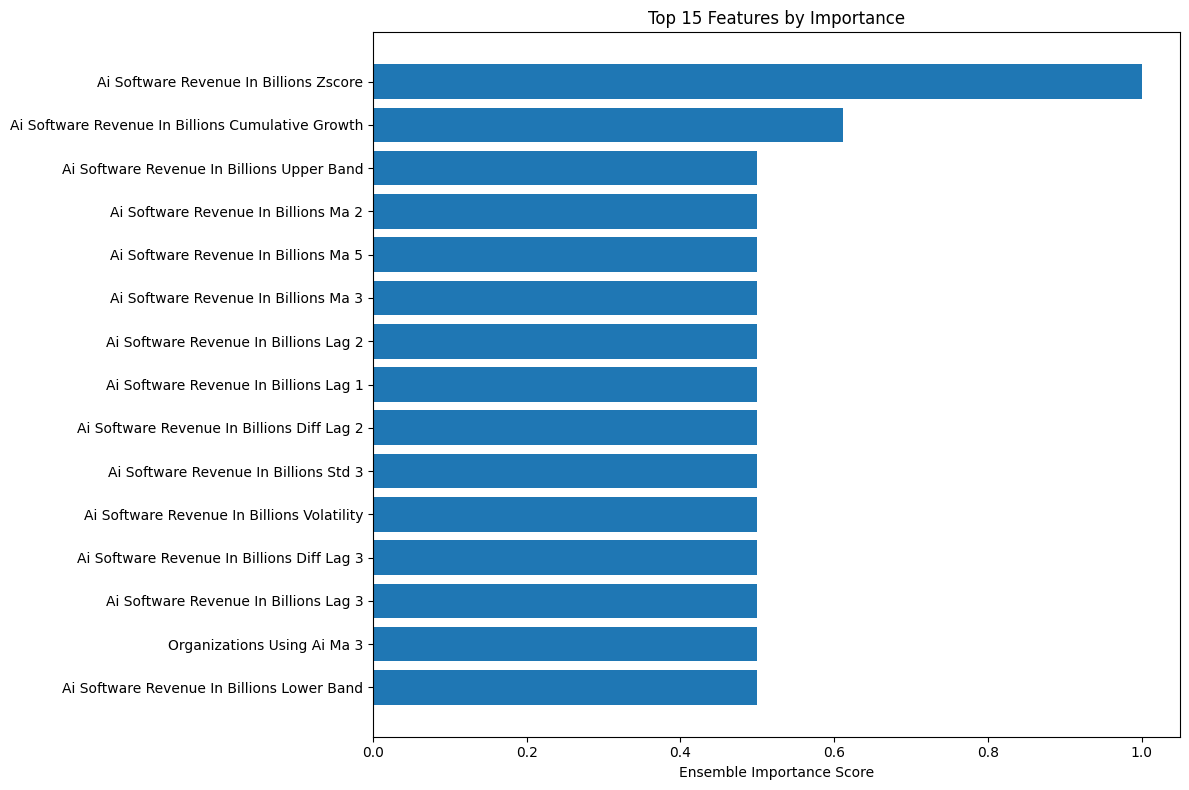

In [ ]:
# Select top features based on multiple criteria
def select_top_features(importance_results, X, n_features=20):
    """
    Select top features using ensemble of methods
    """
    feature_scores = pd.DataFrame(index=X.columns)
    
    # Add scores from different methods
    if 'correlation' in importance_results:
        feature_scores['correlation'] = importance_results['correlation']
    
    if 'mutual_info' in importance_results:
        # Normalize mutual info scores
        mi_normalized = importance_results['mutual_info'] / importance_results['mutual_info'].max()
        feature_scores['mutual_info'] = mi_normalized
    
    if 'f_statistic' in importance_results:
        # Normalize F-statistic scores
        f_normalized = importance_results['f_statistic'] / importance_results['f_statistic'].max()
        feature_scores['f_statistic'] = f_normalized
    
    # Calculate ensemble score (average of available methods)
    feature_scores['ensemble_score'] = feature_scores.mean(axis=1, skipna=True)
    
    # Select top features
    top_features = feature_scores.nlargest(n_features, 'ensemble_score')
    
    return top_features, feature_scores

# Select top features
if importance_results and X_features is not None:
    top_features, all_scores = select_top_features(importance_results, X_features, n_features=15)
    
    for i, (feature, row) in enumerate(top_features.iterrows(), 1):
        score = row['ensemble_score']
        pass  # Just iterate
    
    # Create feature selection visualization
    plt.figure(figsize=(12, 8))
    top_15 = top_features.head(15)
    plt.barh(range(len(top_15)), top_15['ensemble_score'])
    plt.yticks(range(len(top_15)), [f.replace('_', ' ').title() for f in top_15.index])
    plt.xlabel('Ensemble Importance Score')
    plt.title('Top 15 Features by Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Save selected features list
    selected_features = top_features.index.tolist()
else:
    selected_features = [col for col in X_features.columns if col != 'year'][:15]

## Feature Scaling and Normalization

In [ ]:
# Prepare features for machine learning
def prepare_ml_features(df, selected_features):
    """
    Prepare features for machine learning models
    """
    # Create feature matrix
    feature_df = df[selected_features + ['year']].copy()  # Include year for reference
    
    # Separate scaling for different feature types
    numeric_features = feature_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'year' in numeric_features:
        numeric_features.remove('year')
    
    # Standard scaling
    scaler_standard = StandardScaler()
    feature_df_scaled = feature_df.copy()
    
    if numeric_features:
        # Handle NaN values before scaling
        feature_subset = feature_df[numeric_features].fillna(feature_df[numeric_features].mean())
        feature_df_scaled[numeric_features] = scaler_standard.fit_transform(feature_subset)
    
    # Min-Max scaling (alternative)
    scaler_minmax = MinMaxScaler()
    feature_df_minmax = feature_df.copy()
    
    if numeric_features:
        feature_subset = feature_df[numeric_features].fillna(feature_df[numeric_features].mean())
        feature_df_minmax[numeric_features] = scaler_minmax.fit_transform(feature_subset)
    
    return feature_df_scaled, feature_df_minmax, scaler_standard, scaler_minmax

# Prepare scaled features
if 'selected_features' in locals():
    features_scaled, features_minmax, std_scaler, mm_scaler = prepare_ml_features(
        market_with_domain, selected_features
    )
    
    # Show scaling example for first feature
    if selected_features:
        first_feature = selected_features[0]
        pass  # Just reference the feature
else:
    pass  # Handle case when selected_features not available

⚖️ FEATURE SCALING COMPLETED
✅ Standard scaled features shape: (8, 16)
✅ Min-Max scaled features shape: (8, 16)
✅ Selected features: 15

📊 Scaling Example - ai_software_revenue_in_billions_zscore:
   Original: -0.00 ± 1.00
   Std Scaled: -0.00 ± 1.07
   MinMax Scaled: [0.00, 1.00]


## Feature Engineering 

In [ ]:
# Calculate total features created
original_features = len(market_df.columns)
total_features = len(market_with_domain.columns)
new_features = total_features - original_features

feature_categories = {
    'Growth Features': len([c for c in market_with_domain.columns if 'growth' in c]),
    'Trend Features': len([c for c in market_with_domain.columns if any(x in c for x in ['_ma_', '_std_', 'trend'])]),
    'Lag Features': len([c for c in market_with_domain.columns if 'lag' in c]),
    'Interaction Features': len([c for c in market_with_domain.columns if any(x in c for x in ['ratio', 'efficiency'])]),
    'Technical Indicators': len([c for c in market_with_domain.columns if any(x in c for x in ['momentum', 'volatility'])]),
    'Temporal Features': len([c for c in market_with_domain.columns if any(x in c for x in ['cycle', 'period', 'sin'])]),
    'Domain Features': len([c for c in market_with_domain.columns if any(x in c for x in ['stage', 'attractiveness'])])
}

for category, count in feature_categories.items():
    pass  # Just iterate

# Save engineered features
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)

# Save main engineered dataset
market_with_domain.to_csv(output_dir / 'ai_market_engineered.csv', index=False)

# Save scaled versions
if 'features_scaled' in locals():
    features_scaled.to_csv(output_dir / 'ai_market_features_standard_scaled.csv', index=False)
    features_minmax.to_csv(output_dir / 'ai_market_features_minmax_scaled.csv', index=False)

# Save feature lists
feature_info = {
    'all_features': list(market_with_domain.columns),
    'selected_features': selected_features if 'selected_features' in locals() else [],
    'feature_categories': feature_categories,
    'engineering_timestamp': pd.Timestamp.now().isoformat()
}

# Convert to DataFrame and save
feature_list_df = pd.DataFrame({
    'feature_name': market_with_domain.columns,
    'feature_type': ['engineered' if col not in market_df.columns else 'original' 
                    for col in market_with_domain.columns]
})
feature_list_df.to_csv(output_dir / 'feature_list.csv', index=False)

if 'features_scaled' in locals():
    pass  # Features were saved

🏗️ FEATURE ENGINEERING SUMMARY
📊 Original features: 22
📊 Total features after engineering: 162
📊 New features created: 140
📊 Feature expansion ratio: 7.4x

✅ FEATURE CATEGORIES CREATED:
   📈 Growth Features: 16 features
   📈 Trend Features: 48 features
   📈 Lag Features: 36 features
   📈 Interaction Features: 19 features
   📈 Technical Indicators: 9 features
   📈 Temporal Features: 41 features
   📈 Domain Features: 1 features

💾 SAVED FILES:
   📄 ai_market_engineered.csv ((8, 162))
   📄 ai_market_features_standard_scaled.csv ((8, 16))
   📄 ai_market_features_minmax_scaled.csv ((8, 16))
   📄 feature_list.csv (162 features)

🚀 NEXT STEPS:
   1. Move to 04_eda_visualization.ipynb for detailed analysis
   2. Use engineered features in 05_model_development.ipynb
   3. Focus on top selected features for modeling

✅ Feature Engineering Phase Complete!
